In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
df_1y = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\UAL_1Y_CDS_prices.csv')
df_1y.rename(columns={'Date': 'date'}, inplace=True)
df_1y['date'] = pd.to_datetime(df_1y['date'])
df_1y.set_index('date', inplace=True)
#Y1_start_date = datetime(2014, 10, 30)
#Y1_end_date = pd.Timestamp(2025, 10, 30) #Doesn't exist in the bond data :(

#Need to get the full historicals for this
df_5y = pd.read_csv(r'C:\Users\LiamRodgers\OneDrive - stevens.edu\FE800\UAL Pricing Data\UAL 5Y CDS Pricing\UAL_5Y_CDS_2014FullData.csv') #Going to need more data for the 5 year CDS prices
df_5y.rename(columns={'Date': 'date', 'Last Price':'PX_LAST'}, inplace=True)
df_5y['date'] = pd.to_datetime(df_5y['date'])
df_5y.set_index('date', inplace=True)

df_10y = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\UAL_10Y_CDS_prices.csv')
Y10_start_date = datetime(2014, 10, 30)
Y10_end_date = datetime(2025, 10, 30)
df_10y.rename(columns={'Date': 'date'}, inplace=True)
df_10y['date'] = pd.to_datetime(df_10y['date'])
df_10y.set_index('date', inplace=True)

df_risk_free = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\risk_free_curve_2015.csv')
df_term_structure = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\CDSdata\CDS_term_structure_UAL.csv')

df_bond_price = pd.read_csv(r'C:\Users\LiamRodgers\Desktop\Python\Classes\FE800\FE800-Research\UAL_hazard_rates.csv')
df_bond_price['date'] = pd.to_datetime(df_bond_price['date'])
df_bond_price = df_bond_price[['date', 'Time_to_Maturity', 'last_value', 'hazard']]
df_bond_price.set_index('date', inplace=True)
Y1_end_date, Y5_end_date, Y10_end_date  = df_bond_price.index[-1], df_bond_price.index[-1], df_bond_price.index[-1]
Y1_start_date, Y5_start_date, Y10_start_date  = df_bond_price.index[0], df_bond_price.index[0], df_bond_price.index[0]
print(Y1_start_date)

2014-06-19 00:00:00


In [4]:
def Bond_CDS_matching(df1, df2):
    #df1 is the CDS data and df2 is the bond price data
    dates = df1.index.intersection(df2.index)
    df1 = df1.loc[dates]
    return df1

In [5]:
df_1y = Bond_CDS_matching(df_1y, df_bond_price)
df_5y = Bond_CDS_matching(df_5y, df_bond_price) #Data issue
df_10y = Bond_CDS_matching(df_10y, df_bond_price)
print(df_10y.shape)
print(df_1y.shape)
print(df_5y.shape) #We dropped three data points here, not sure why

(485, 1)
(485, 1)
(482, 1)


In [6]:
df_CDS_Bond = pd.merge(df_bond_price, df_1y, how = 'outer',left_index=True, right_index=True, suffixes=('_Bond', '_CDS'))
#Need to add year 5, but we have bad data
df_CDS_Bond = pd.merge(df_CDS_Bond, df_5y, how = 'outer',left_index=True, right_index=True, suffixes=('', '_CDS_5Y'))

df_CDS_Bond = pd.merge(df_CDS_Bond, df_10y, how = 'outer',left_index=True, right_index=True, suffixes=('', '_CDS_10Y'))
print(df_CDS_Bond.shape)
df_CDS_Bond.dropna(inplace=True)
print(df_CDS_Bond.shape) #Had to drop due to missing CDS data 
df_CDS_Bond


(515, 6)
(482, 6)


,Time_to_Maturity,last_value,hazard,PX_LAST,PX_LAST_CDS_5Y,PX_LAST_CDS_10Y
date,,,,,,
2014-11-24,11.386301,138.1860,0.023031,55.430,330.405,385.354
2014-12-02,11.364384,150.3210,0.025053,53.919,314.295,381.713
2014-12-03,11.361644,140.9150,0.023486,52.711,312.805,383.497
2014-12-04,11.358904,152.5260,0.025421,51.723,319.405,369.609
2014-12-05,11.356164,139.6520,0.023275,49.216,319.470,361.184
...,...,...,...,...,...,...
2025-08-28,0.619178,81.3715,0.013562,23.344,169.740,139.541
2025-09-18,0.561644,83.7145,0.013952,25.224,183.010,141.835
2025-09-23,0.547945,90.6029,0.015100,27.369,190.555,151.791


In [7]:
from datetime import datetime, timedelta
from scipy.optimize import root_scalar

def generate_payment_dates(start_date, end_date, freq_months=3):
    """Return a list of quarterly payment dates from start_date to end_date."""
    pay_dates = []
    current_date = start_date
    while current_date < end_date:
        pay_dates.append(current_date)
        current_date += timedelta(days=(freq_months * 30.44))  # approximate month length
    pay_dates.append(end_date)
    return pay_dates

def get_discount_factor(df_risk_free, payment_date, obs_date):
    tenor = (payment_date - obs_date).days / 365.0
    # Interpolate risk-free rate using nearest available tenors
    match = df_risk_free.loc[np.abs(df_risk_free['tenor'] - tenor).idxmin()]
    rate = match['rate']
    discount = np.exp(-rate * tenor)
    return discount

def bootstrap_hazard(df_cds_series, payment_dates, df_risk_free, obs_date, recovery_rate):
    """
    Piecewise constant hazard rate bootstrapping for survival-based CDS pricing.
    df_cds_series: DataFrame with 'Date' (index) and 'PX_LAST'.
    payment_dates: dates for current tenor (quarterly)
    df_risk_free: risk-free curve DataFrame with 'tenor', 'rate' columns
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    """
    cds_spread = df_cds_series.loc[obs_date, 'PX_LAST'] / 10000  # convert bps to decimal
    f = 0.25  # quarterly payments

    N = len(payment_dates) - 1
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    # Objective: CDS pricing equation root in hazard h for this interval
    def cds_pricer(h):
        Q_local = [1.0]
        for i in range(N):
            dt = (payment_dates[i+1]-payment_dates[i]).days / 365.0
            Q_local.append(Q_local[-1]*np.exp(-h*dt))
        numer = sum([f * discounts[i] * (Q_local[i]-Q_local[i+1]) * (1-recovery_rate) for i in range(N)])
        denom = sum([f * discounts[i] * Q_local[i] for i in range(N)])
        return numer/denom - cds_spread
    # Solve for hazard rate
    sol = root_scalar(cds_pricer, bracket=[1e-6, 2.0], method='bisect')
    h_est = sol.root
    return h_est




In [8]:
#Usage:
bond_maturity = datetime(2026, 4, 11)
#I dont think we need this any more, because we are taking the bond hazard rates
payment_dates = generate_payment_dates(Y1_start_date, bond_maturity, 3)
h_1y = bootstrap_hazard(df_1y, payment_dates, df_risk_free, Y1_end_date, 0.4)
h_5y = bootstrap_hazard(df_5y, payment_dates, df_risk_free, Y5_end_date, 0.4)
h_10y = bootstrap_hazard(df_10y, payment_dates, df_risk_free, Y10_end_date, 0.4)

# Repeat for 5Y and 10Y intervals, then stitch together to create piecewise hazard rate term structure.

In [9]:
Y1_end_date.normalize() 
Y1_end_date.date()

datetime.date(2025, 9, 30)

In [10]:
y1_bond_hazard = df_bond_price.loc[Y1_end_date, 'hazard']

print(y1_bond_hazard)
print(h_1y)
df_CDS_Bond

0.0137327166666666
0.018516914568309405


,Time_to_Maturity,last_value,hazard,PX_LAST,PX_LAST_CDS_5Y,PX_LAST_CDS_10Y
date,,,,,,
2014-11-24,11.386301,138.1860,0.023031,55.430,330.405,385.354
2014-12-02,11.364384,150.3210,0.025053,53.919,314.295,381.713
2014-12-03,11.361644,140.9150,0.023486,52.711,312.805,383.497
2014-12-04,11.358904,152.5260,0.025421,51.723,319.405,369.609
2014-12-05,11.356164,139.6520,0.023275,49.216,319.470,361.184
...,...,...,...,...,...,...
2025-08-28,0.619178,81.3715,0.013562,23.344,169.740,139.541
2025-09-18,0.561644,83.7145,0.013952,25.224,183.010,141.835
2025-09-23,0.547945,90.6029,0.015100,27.369,190.555,151.791


In [11]:
print(f"Hazard rate per tenor interval: 1Y: {h_1y:.4%}, #5Y: {h_5y:.4%}, 10Y: {h_10y:.4%}")
#Details: Hazard rates are fit per tenor interval, these are a single value is calculated across the structures, not a curve, since the curve is term structure of each tenor
#Hazard rate should always be an annualized decimal 


Hazard rate per tenor interval: 1Y: 1.8517%, #5Y: 13.2017%, 10Y: 10.3732%


In [12]:
def construct_survival_curve(payment_dates, hazard_rates, segment_starts):
    """
    Build survival probability Q(0,t) for each payment date using piecewise constant hazard rates.
    payment_dates: sorted list of payment dates (datetime)
    hazard_rates: list of hazard rates per segment (from bootstrapping for [0,1Y], [1Y,5Y], ...)
    segment_starts: list of start dates for each segment
    Returns: list of survival probabilities Q(0,t)
    """
    Q = [1.0]
    for i in range(1, len(payment_dates)):
        t = payment_dates[i]
        # Find the segment index
        for j in range(len(segment_starts)-1, -1, -1):
            if t >= segment_starts[j]:
                h = hazard_rates[j]
                t_prev = payment_dates[i-1]
                dt = (t - t_prev).days / 365.0
                Q.append(Q[-1] * np.exp(-h * dt))
                break
    return Q

def cds_par_spread(payment_dates, Q, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate survival-based par CDS spread for given payment dates and survival curve.
    payment_dates: list of CDS payment dates
    Q: survival probabilities for each payment date
    df_risk_free: DataFrame with risk-free curve
    obs_date: valuation date
    recovery_rate: assumed recovery (e.g., 0.4)
    f: payment frequency (quarterly=0.25)
    """
    N = len(payment_dates) - 1 
    discounts = [get_discount_factor(df_risk_free, payment_dates[i+1], obs_date) for i in range(N)]
    numer = sum([f * discounts[i] * (Q[i]-Q[i+1]) * (1-recovery_rate) for i in range(N)])
    denom = sum([f * discounts[i] * Q[i] for i in range(N)])
    par_spread = numer / denom
    return par_spread

def bond_implied_cds(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f=0.25):
    """
    Calculate bond-implied CDS spread (BCDS) based on fitted bond survival curve Q_bond.
    Same calculation as cds_par_spread, but Q_bond from bond fitting.
    """
    return cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)

def cds_bond_basis(payment_dates, Q_bond, Q_cds, df_risk_free, obs_date, recovery_rate, market_cds_spread, f=0.25):
    """
    Compare bond-implied CDS (BCDS) to actual market CDS for given maturity.
    Returns: Curve Basis (BCDS - market CDS spread)
    """
    bcds = cds_par_spread(payment_dates, Q_bond, df_risk_free, obs_date, recovery_rate, f)
    curve_basis = bcds - market_cds_spread
    
    print(f"Market {market_cds_spread}\nBond-implied {bcds}\nCurve Basis: {curve_basis}")
    
    return curve_basis


In [13]:
#Calculating the CDS-Bond basis for each tenor interval using the bootstrapped hazard rates and survival curves.
# For example:
payment_dates_1y = generate_payment_dates(Y1_start_date, Y1_end_date, 3)
payment_dates_5y = generate_payment_dates(Y5_start_date, Y5_end_date, 3)
payment_dates_10y = generate_payment_dates(Y10_start_date, Y10_end_date, 3)

# Segments (start dates for each hazard rate interval):
segment_starts = [Y1_start_date, Y5_start_date, Y10_start_date]
hazard_rates = [h_1y, h_5y, h_10y]  # output from bootstrapping for each segment

# For all payment dates (combine the arrays as needed):
all_payment_dates = payment_dates_1y + payment_dates_5y[1:] + payment_dates_10y[1:]
survival_probs = construct_survival_curve(all_payment_dates, hazard_rates, segment_starts)


In [14]:

######################################################################################
# Pick interval/payment dates and corresponding survival probs:
#For 1Y CDS:
spread_1y = cds_par_spread(payment_dates_1y, survival_probs[:len(payment_dates_1y)], df_risk_free, Y1_end_date, recovery_rate=0.4)
print("Fair CDS par spread for 1Y tenor:", spread_1y)
Q_bond_1y = construct_survival_curve(payment_dates_1y, [h_1y], [Y1_start_date])
# Bond-implied CDS (if you fitted Q_bond from bond prices)
bcds_1y = bond_implied_cds(payment_dates_1y, Q_bond_1y, df_risk_free, Y1_end_date, recovery_rate=0.4) #Bond Implied CDS Spread
# CDS-Bond Basis (compare BCDS to market spread)
#market_cds_1y = h_1y
market_cds_1y = df_1y.loc[Y1_end_date, 'PX_LAST'] / 10000  # Convert bps to decimal for market CDS spread
basis_1y = cds_bond_basis(payment_dates_1y, Q_bond_1y, survival_probs[:len(payment_dates_1y)], df_risk_free, Y1_end_date, recovery_rate=0.4, market_cds_spread=market_cds_1y)
print(f"CDS-Bond Basis for 1Y tenor: {basis_1y:.1f}")

######################################################################################

#Note: We are measuring the fair CDS spread compared to the market spread, when CDS prices jump, we should see the spread difference compared to the fair market spread, which we are measuring
#BCDS: Bond-implied CDS Spread
#Now we need to model when the CDS spread increase during the event

Fair CDS par spread for 1Y tenor: 0.01516448387547091
Market 0.002724
Bond-implied 0.002716121901511496
Curve Basis: -7.878098488504036e-06
CDS-Bond Basis for 1Y tenor: -0.0


In [15]:
# For 5Y CDS:
spread_5y = cds_par_spread(payment_dates_5y, survival_probs[:len(payment_dates_5y)], df_risk_free, Y5_end_date, recovery_rate=0.4)
print("\nFair CDS par spread for 5Y tenor:", spread_5y)
Q_bond_5y = construct_survival_curve(payment_dates_5y, [h_5y], [Y5_start_date])
# Bond-implied CDS (if you fitted Q_bond from bond prices)
bcds_5y = bond_implied_cds(payment_dates_5y, Q_bond_5y, df_risk_free, Y5_end_date, recovery_rate=0.4)
# CDS-Bond Basis (compare BCDS to market spread)
market_cds_5y = df_5y.loc[Y5_end_date, 'PX_LAST'] / 10000  # Convert bps to decimal for market CDS spread
basis_5y = cds_bond_basis(payment_dates_5y, Q_bond_5y, survival_probs[:len(payment_dates_5y)], df_risk_free, Y5_end_date, recovery_rate=0.4, market_cds_spread=market_cds_5y)
print("CDS-Bond Basis for 5Y tenor:", basis_5y)


Fair CDS par spread for 5Y tenor: 0.01516448387547091
Market 0.019298
Bond-implied 0.01926634859976115
Curve Basis: -3.16514002388496e-05
CDS-Bond Basis for 5Y tenor: -3.16514002388496e-05


In [16]:
#For 10Y CDS:
spread_10y = cds_par_spread(payment_dates_10y, survival_probs[:len(payment_dates_10y)], df_risk_free, Y10_end_date, recovery_rate=0.4)
print("\nFair CDS par spread for 10Y tenor:", spread_10y)
Q_bond_10y = construct_survival_curve(payment_dates_10y, [h_10y], [Y10_start_date])
# Bond-implied CDS (if you fitted Q_bond from bond prices)
bcds_10y = bond_implied_cds(payment_dates_10y, Q_bond_10y, df_risk_free, Y10_end_date, recovery_rate=0.4)
# CDS-Bond Basis (compare BCDS to market spread)
market_cds_10y = df_10y.loc[Y10_end_date, 'PX_LAST'] / 10000  # Convert bps to decimal for market CDS spread
basis_10y = cds_bond_basis(payment_dates_10y, Q_bond_10y, survival_probs[:len(payment_dates_10y)], df_risk_free, Y10_end_date, recovery_rate=0.4, market_cds_spread=market_cds_10y)
print("CDS-Bond Basis for 10Y tenor:", basis_10y)


Fair CDS par spread for 10Y tenor: 0.01516448387547091


Market 0.0151935
Bond-implied 0.01516448387547091
Curve Basis: -2.901612452908993e-05
CDS-Bond Basis for 10Y tenor: -2.901612452908993e-05


In [ ]:
#This needs to get created into a function to reproduce for the other years***

basis_series = []

for historical_date in df_CDS_Bond.index:
    h_1y_today = df_CDS_Bond.loc[historical_date, 'hazard'] #Bond hazard rates
    Q_bond_1y_today = construct_survival_curve(payment_dates_1y, [h_1y_today], [Y1_start_date])
    bcds_1y_today = bond_implied_cds(payment_dates_1y, Q_bond_1y_today, df_risk_free, historical_date, 0.4)
    market_cds_1y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST'] / 10000 #In bps
    basis_today = bcds_1y_today - market_cds_1y_today
    basis_series.append({'Date': historical_date, 'CDS_Basis': basis_today})
    
basis_1y = pd.DataFrame(basis_series)
basis_1y['Date'] = pd.to_datetime(basis_1y['Date'])
basis_1y['CDS_Basis'] = round(basis_1y['CDS_Basis'], 3)
basis_1y['CDS_Basis'].sum()
#We need to use a piecewise hazard rate curve here, which are not using here

np.float64(-1.5230000000000001)

In [18]:
df_CDS_Bond.head()

,Time_to_Maturity,last_value,hazard,PX_LAST,PX_LAST_CDS_5Y,PX_LAST_CDS_10Y
date,,,,,,
2014-11-24,11.386301,138.186,0.023031,55.430,330.405,385.354
2014-12-02,11.364384,150.321,0.025053,53.919,314.295,381.713
2014-12-03,11.361644,140.915,0.023486,52.711,312.805,383.497
2014-12-04,11.358904,152.526,0.025421,51.723,319.405,369.609
2014-12-05,11.356164,139.652,0.023275,49.216,319.470,361.184


In [19]:
df_risk_free

,tenor,rate,discount_factor
0,0.25,0.0003,0.999925
1,0.50,0.0012,0.999400
2,1.00,0.0027,0.997304
3,2.00,0.0056,0.988862
4,3.00,0.0087,0.974238
5,5.00,0.0135,0.934728
6,7.00,0.0167,0.889674
7,10.00,0.0190,0.826959


In [20]:
basis_series = []

for historical_date in df_CDS_Bond.index:
    h_5y_today = df_CDS_Bond.loc[historical_date, 'hazard'] #Bond hazard rates
    Q_bond_5y_today = construct_survival_curve(payment_dates_5y, [h_5y_today], [Y5_start_date])
    bcds_5y_today = bond_implied_cds(payment_dates_5y, Q_bond_5y_today, df_risk_free, historical_date, 0.4)
    market_cds_5y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_5Y'] / 10000 #In bps
    basis_today = bcds_5y_today - market_cds_5y_today
    basis_series.append({'Date': historical_date, 'CDS_Basis': basis_today})
    
basis_5y = pd.DataFrame(basis_series)
basis_5y['Date'] = pd.to_datetime(basis_5y['Date'])
basis_5y['CDS_Basis'] = round(basis_5y['CDS_Basis'], 3)
basis_5y['CDS_Basis'].sum()

np.float64(-16.602000000000004)

In [21]:
basis_series = []

for historical_date in df_CDS_Bond.index:
    h_10y_today = df_CDS_Bond.loc[historical_date, 'hazard'] #Bond hazard rates
    Q_bond_10y_today = construct_survival_curve(payment_dates_10y, [h_10y_today], [Y10_start_date])
    bcds_10y_today = bond_implied_cds(payment_dates_10y, Q_bond_10y_today, df_risk_free, historical_date, 0.4)
    market_cds_10y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_10Y'] / 10000 #In bps
    basis_today = bcds_10y_today - market_cds_10y_today
    basis_series.append({'Date': historical_date, 'CDS_Basis': basis_today})
    
basis_10y = pd.DataFrame(basis_series)
basis_10y['Date'] = pd.to_datetime(basis_10y['Date'])
basis_10y['CDS_Basis'] = round(basis_10y['CDS_Basis'], 3)
basis_10y['CDS_Basis'].sum()

np.float64(-12.253000000000002)

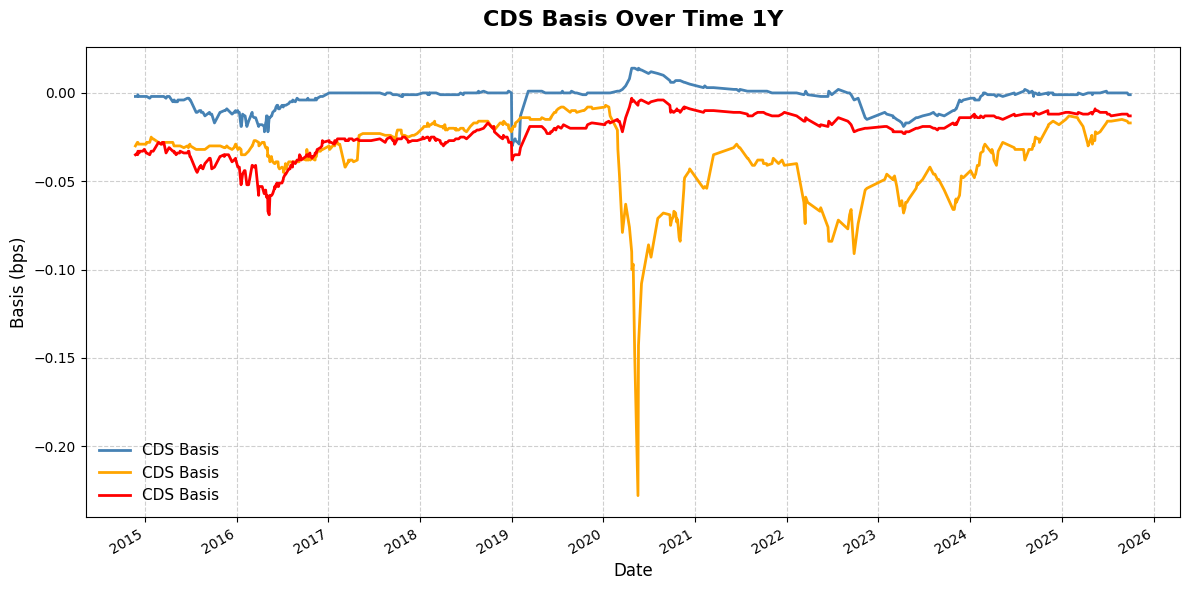

In [22]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))  # 12x6 inches is a good aspect ratio for reports

# Plot line
plt.plot(
    basis_1y['Date'],
    basis_1y['CDS_Basis'],
    color='steelblue',
    linewidth=2,
    label='CDS Basis'
)

plt.plot(
    basis_5y['Date'],
    basis_5y['CDS_Basis'],
    color='orange',
    linewidth=2,
    label='CDS Basis',
)
plt.plot(
    basis_10y['Date'], #Something is wrong with 10y
    basis_10y['CDS_Basis'],
    color='red',
    linewidth=2,
    label='CDS Basis',
)

# Title and labels
plt.title('CDS Basis Over Time 1Y', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Basis (bps)', fontsize=12)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # rotate date labels

# Add grid and legend
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.legend(frameon=False, fontsize=11)

# Clean up layout
plt.tight_layout()
plt.show()

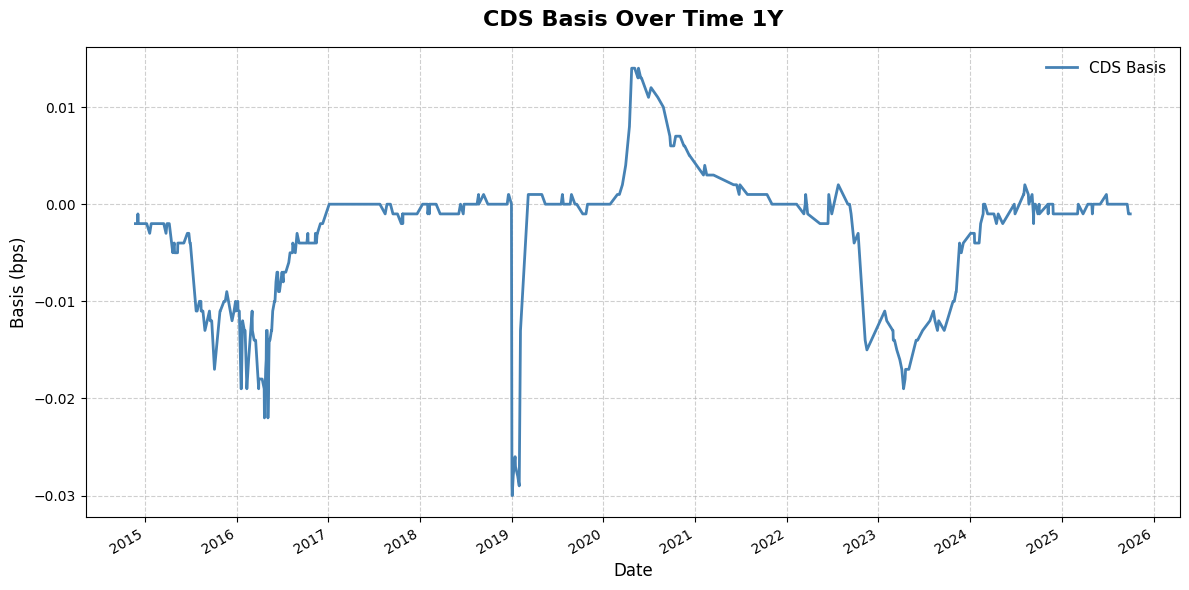

In [23]:
import matplotlib.dates as mdates
#This seems correct, but the 10y above is not around 0, interesting
plt.figure(figsize=(12, 6))  # 12x6 inches is a good aspect ratio for reports

# Plot line
plt.plot(
    basis_1y['Date'],
    basis_1y['CDS_Basis'],
    color='steelblue',
    linewidth=2,
    label='CDS Basis'
)

# Title and labels
plt.title('CDS Basis Over Time 1Y', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Basis (bps)', fontsize=12)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # rotate date labels

# Add grid and legend
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.legend(frameon=False, fontsize=11)

# Clean up layout
plt.tight_layout()
plt.show()

In [27]:
basis_series = []

for historical_date in df_CDS_Bond.index:
    # Get all hazard segment values for that date
    hazards_today = [
        df_CDS_Bond.loc[historical_date, 'hazard'],
        df_CDS_Bond.loc[historical_date, 'hazard'],
        df_CDS_Bond.loc[historical_date, 'hazard']
    ]
    segment_starts = [Y1_start_date, Y5_start_date, Y10_start_date]
    # Build the full term structure for all relevant payment dates
    Q_bond_full_today = construct_survival_curve(all_payment_dates, hazards_today, segment_starts)
    # Now slice Q and use the right section for each tenor!
    
    # 1Y
    Q_bond_1y = Q_bond_full_today[:len(payment_dates_1y)]
    bcds_1y_today = bond_implied_cds(payment_dates_1y, Q_bond_1y, df_risk_free, historical_date, 0.4)
    market_cds_1y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST'] / 10000
    basis_1y = bcds_1y_today - market_cds_1y_today

    # 5Y (similarly, slice Q for 5Y period)
    Q_bond_5y = Q_bond_full_today[:len(payment_dates_5y)]
    bcds_5y_today = bond_implied_cds(payment_dates_5y, Q_bond_5y, df_risk_free, historical_date, 0.4)
    market_cds_5y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_5Y'] / 10000
    basis_5y = bcds_5y_today - market_cds_5y_today

    # 10Y
    Q_bond_10y = Q_bond_full_today[:len(payment_dates_10y)]
    bcds_10y_today = bond_implied_cds(payment_dates_10y, Q_bond_10y, df_risk_free, historical_date, 0.4)
    market_cds_10y_today = df_CDS_Bond.loc[historical_date, 'PX_LAST_CDS_10Y'] / 10000
    basis_10y = bcds_10y_today - market_cds_10y_today

    # Store basis for all tenors for this date
    basis_series.append({
        'Date': historical_date,
        'CDS_Basis_1Y': basis_1y,
        'CDS_Basis_5Y': basis_5y,
        'CDS_Basis_10Y': basis_10y
    })

basis_df = pd.DataFrame(basis_series)
basis_df['Date'] = pd.to_datetime(basis_df['Date'])
for tenor in ['1Y', '5Y', '10Y']:
    basis_df[f'CDS_Basis_{tenor}'] = round(basis_df[f'CDS_Basis_{tenor}'], 3)


In [28]:
basis_df

,Date,CDS_Basis_1Y,CDS_Basis_5Y,CDS_Basis_10Y
0,2014-11-24,-0.002,-0.030,-0.035
1,2014-12-02,-0.002,-0.028,-0.034
2,2014-12-03,-0.002,-0.028,-0.035
3,2014-12-04,-0.001,-0.028,-0.033
4,2014-12-05,-0.002,-0.029,-0.033
...,...,...,...,...
477,2025-08-28,-0.000,-0.015,-0.012
478,2025-09-18,-0.000,-0.016,-0.012
479,2025-09-23,-0.001,-0.017,-0.013
480,2025-09-29,-0.001,-0.017,-0.013


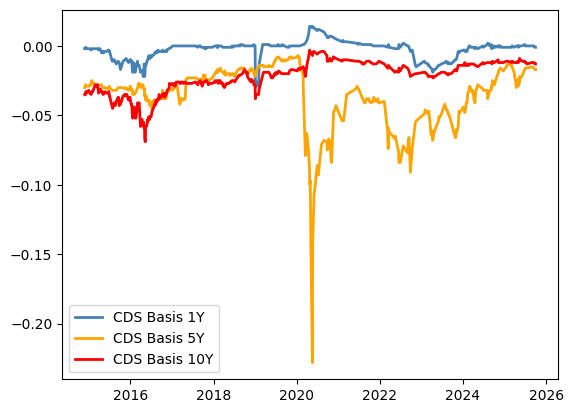

In [29]:
plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_1Y'],
    color='steelblue',
    linewidth=2,
    label='CDS Basis 1Y'
)
plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_5Y'],
    color='orange',
    linewidth=2,
    label='CDS Basis 5Y'
)

plt.plot(
    basis_df['Date'],
    basis_df['CDS_Basis_10Y'],
    color='red',
    linewidth=2,
    label='CDS Basis 10Y'
)
plt.legend()
plt.show()

In [ ]:
#The longer tenors are fitting under the 0 basis because we have a flat curve (only one bond). In order to see the full curve we need to get more bonds from UAL
#to truly measure the risk of the longer tenor CDS spread, this is the limitation of the CDS structure that the longer tenor CDSs are typically underpriced